# Breast Cancer Wisconsin (Diagnostic) Data Set

## Introduction

In this notebook we will explore some algorithms to detect whether a breast tumor is malignant or benign. The dataset we analize can be found [here](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/home), was created by Dr. William H. Wolberg, W. Nick Street and Olvi L. Mangasarian from the University of Wisconsin and was donated by W. Nick Sreet. 

The dataset consists of 569 data points with 32 attributes, divided in several categories (as described [here](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29))

Attribute Information:

* 1. ID number 
* 2. Diagnosis (M = malignant, B = benign) 
* 3. , 32. 

Ten real-valued features:

* a. radius (mean of distances from center to points on the perimeter) 
* b. texture (standard deviation of gray-scale values) 
* c. perimeter 
* d. area 
* e. smoothness (local variation in radius lengths) 
* f. compactness (perimeter^2 / area - 1.0) 
* g. concavity (severity of concave portions of the contour) 
* h. concave points (number of concave portions of the contour) 
* i. symmetry 
* j. fractal dimension ("coastline approximation" - 1)

A brief description of some of the real-valued attributes can be found [here](https://pdfs.semanticscholar.org/1c4a/4db612212a9d3806a848854d20da9ddd0504.pdf).

For this kernel, we will use 4 different base models, and with their results and a few important features, we will train two alternative models to try predicting the response on a test dataset.

## Parameter tuning and error testing

Since we will be using a two layers model, we think it is worth giving a few words about the issues of parameter tuning and how to measure the test error. 

We will initially separate the dataset in three different batches: (X_train,y_train), (X_tun,y_tun) and (X_test,y_test), and their relative sizes are 70%, 15% and 15%. The first batch (X_train,y_train) will be used to train **both** layers of the model, the second (X_tun,y_tun) will be used to tune the parameters of both layers of models, and the third bath (X_test,y_test) will be used to assess the generalization power of the model. It is important to remark that we will tune the parameters of both layers at the same time. If we used (X_tun,y_tun) to tune the first layer and (X_test,y_test), information would be [leaked](https://en.wikipedia.org/wiki/Information_leakage) and our test error would be skewed.

## Loading and examining the data

We load the data into a dataframe structure using pandas:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
#Import the data into a dataframe
df = pd.read_csv("cancer_data.csv", encoding = 'ISO-8859-1')

Let us examine some basic properties of our dataframe, such as the shape, the names of the columns and the types of its values:

In [3]:
#Shape of the dataframe
df.shape

(569, 33)

Note that there are 33 columns instead of 32 as mentioned in the description. Let us have a look at the columns:

In [4]:
#Names of the columns
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

We can see that there is a column called 'Unnamed: 32' which we do not expect. Now we check the types of each column.

In [5]:
#Types of the elements of the dataframe
df.dtypes

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

We can see that most of the features are of numeric type except for the column 'diagnosis', which we can expect it to be non-numeric. The column 'Unnamed: 32' seems to have numerical values. Let us have a look at it:

In [6]:
df['Unnamed: 32'].head(15)

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
12   NaN
13   NaN
14   NaN
Name: Unnamed: 32, dtype: float64

It seems like it consists mostly of NaN values. We can check that this is the case:

In [7]:
df['Unnamed: 32'].isna().sum()

569

We can confirm then that this column does not have any relevant information, and hence can be disregarded from our dataframe. We check that the other columns do not contain any NaN entry:

In [8]:
df.isnull().any()

id                         False
diagnosis                  False
radius_mean                False
texture_mean               False
perimeter_mean             False
area_mean                  False
smoothness_mean            False
compactness_mean           False
concavity_mean             False
concave points_mean        False
symmetry_mean              False
fractal_dimension_mean     False
radius_se                  False
texture_se                 False
perimeter_se               False
area_se                    False
smoothness_se              False
compactness_se             False
concavity_se               False
concave points_se          False
symmetry_se                False
fractal_dimension_se       False
radius_worst               False
texture_worst              False
perimeter_worst            False
area_worst                 False
smoothness_worst           False
compactness_worst          False
concavity_worst            False
concave points_worst       False
symmetry_w

We now index the dataframe using the 'id' column:

In [9]:
df = df.set_index('id')

We can see now that the diagnosis is encoded using strings, M for malignant and B for benign:

In [10]:
type(df['diagnosis'].iloc[2])

str

We proceed to encode the values of 'diagnosis' using numerical features. For this, we use the label encoder tool of sklearn:

In [11]:
le = preprocessing.LabelEncoder()
le.fit(df['diagnosis'])

LabelEncoder()

And now we can modify the dataframe to have numerical values:

In [12]:
df['diagnosis'] = le.transform(df['diagnosis'])

We separate now the features (X) from the responses (y). We do not include the column 'Unnamed: 32' in the features dataframe, as it provides no information.

In [13]:
X = df[df.columns[1:-1]]
y = df['diagnosis']

We also want to check if we are dealing with an unbalanced dataset, and hence, we should treat at as an anomaly detection problem rather than a classification problem:

In [14]:
# Benign, malignant
sum(y == 0) , sum(y == 1)

(357, 212)

Now we can use the train-test split function of sklearn to separate the dataset into the three batches described above. We will call the function twice, first to separate the training data, and then to divide the rest into tuning and test data.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y , test_size = 0.3)
X_tun, X_test, y_tun, y_test = train_test_split(X_temp, y_temp,test_size=0.5)

In [16]:
X_tun.shape , y_tun.shape

((85, 30), (85,))

Finally, we look at the correlations between the different features of the dataset:

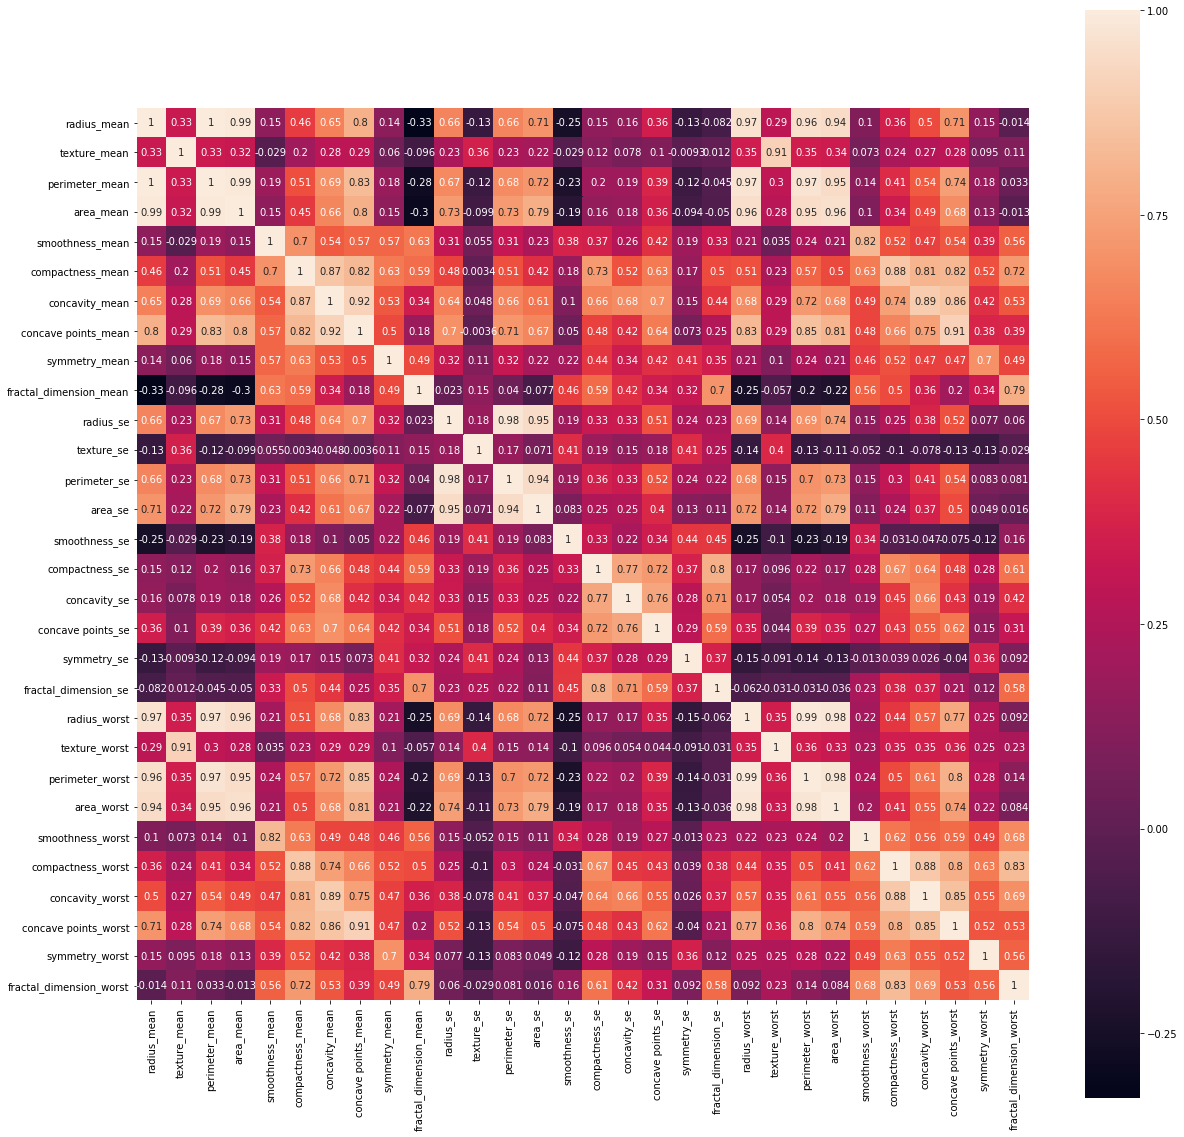

In [17]:
import seaborn as sns

corr_train = X_train.corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr_train,annot=True ,square=True);

This will be useful later on when we build the second layer model.

## First layer of models

Now we proceed to build the first layer of models. This will consist of four different models trained using the same batch of data, (X_train,y_train). The models that we will use for the first layer are:
 
1. K-nearest neighbor 
2. Neural network
3. Gradient-boosted decision tree
4. Random forest


We remark that each of the models is powerful enough to yield accurate predictions, but by making them work together, we expect to obtain even higher performance. We import the different models from the sklearn library:

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

C:\Users\fp16987\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


We will assess the performance of the different models using accuracy, precision, recall and F1 scores. Looking at the confusion matrix will also provide some useful information. Sklearn provides tools for this task:

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### 1. K-nearest neighbor

We will use the K-nearest neighbor algorithm with k=5 and the usual Euclidian metric.

In [20]:
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

We compute the predictions of the model on the tuning set

In [21]:
knn_tun = knn.predict(X_tun)
confusion_matrix(y_tun,knn_tun)

array([[49,  1],
       [ 3, 32]], dtype=int64)

In [22]:
print(classification_report(y_tun, knn_tun))

             precision    recall  f1-score   support

          0       0.94      0.98      0.96        50
          1       0.97      0.91      0.94        35

avg / total       0.95      0.95      0.95        85



In [23]:
accuracy_score(y_tun, knn_tun)

0.9529411764705882

### 2. Neural network

For the neural network, we will use the lbfgs optimizer, tanh activation function, the regularization parameter alpha = 1 and an arquitecture of three layers with nodes [64,64,32]. We fit the neural network using the training data:

In [24]:
nn = MLPClassifier(solver='lbfgs', activation = 'tanh', alpha = 1,
                         hidden_layer_sizes = [64, 64,32])
nn.fit(X_train, y_train)

MLPClassifier(activation='tanh', alpha=1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[64, 64, 32], learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

Now we evaluate its performance using the tuning dataset:

In [25]:
nn_tun = nn.predict(X_tun)

In [26]:
confusion_matrix(y_tun,nn_tun)

array([[50,  0],
       [ 4, 31]], dtype=int64)

In [27]:
print(classification_report(y_tun, nn_tun))

             precision    recall  f1-score   support

          0       0.93      1.00      0.96        50
          1       1.00      0.89      0.94        35

avg / total       0.96      0.95      0.95        85



In [28]:
accuracy_score(y_tun, nn_tun)

0.9529411764705882

### 3. Gradient-boosted decision trees

For the gradient-boosted decision tree, we use the default parameters. We fit it using the training data:

In [29]:
gbt = GradientBoostingClassifier()
gbt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

We evaluate now its performance using the tuning data:

In [30]:
gbt_tun = gbt.predict(X_tun)

In [31]:
confusion_matrix(y_tun,gbt_tun)

array([[49,  1],
       [ 2, 33]], dtype=int64)

In [32]:
print(classification_report(y_tun, gbt_tun))

             precision    recall  f1-score   support

          0       0.96      0.98      0.97        50
          1       0.97      0.94      0.96        35

avg / total       0.96      0.96      0.96        85



In [33]:
accuracy_score(y_tun, gbt_tun)

0.9647058823529412

### 4. Random forest

For the random forest model, we set the parameters to max_depth = 9 and min_samples_leaf = 5 to avoid overfitting. We train the model using the training data:

In [34]:
rf = RandomForestClassifier(max_depth = 9 , min_samples_leaf = 5 )
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Now we evaluate it using the tuning data:

In [35]:
rf_tun = rf.predict(X_tun)

In [36]:
confusion_matrix(y_tun,rf_tun)

array([[50,  0],
       [ 2, 33]], dtype=int64)

In [37]:
print(classification_report(y_tun, rf_tun))

             precision    recall  f1-score   support

          0       0.96      1.00      0.98        50
          1       1.00      0.94      0.97        35

avg / total       0.98      0.98      0.98        85



In [38]:
accuracy_score(y_tun, rf_tun)

0.9764705882352941

## Features importance

Using the random forest model and the gradient-boosted decision trees, we can see what are the most important features for these models. For the random forest:

In [39]:
feat_imp_rf = pd.DataFrame([X.columns,rf.feature_importances_]).T

In [40]:
feat_imp_rf.sort_values(by=1,ascending=False)

,0,1
23,area_worst,0.208254
3,area_mean,0.161006
27,concave points_worst,0.148978
22,perimeter_worst,0.116578
20,radius_worst,0.0527221
5,compactness_mean,0.0510983
21,texture_worst,0.0495621
25,compactness_worst,0.0440387
16,concavity_se,0.035073
17,concave points_se,0.0332096


For the gradient-boosted decision trees:

In [41]:
feat_imp_gbt = pd.DataFrame([X.columns,gbt.feature_importances_]).T

In [42]:
feat_imp_gbt.sort_values(by=1,ascending=False)

,0,1
27,concave points_worst,0.120766
20,radius_worst,0.104893
23,area_worst,0.0869559
21,texture_worst,0.0820552
22,perimeter_worst,0.073789
13,area_se,0.0601569
28,symmetry_worst,0.0498966
26,concavity_worst,0.0436799
1,texture_mean,0.0403795
7,concave points_mean,0.0398975


We can see that some features did not contribute to the predictions of the random forest model. Some of these features also barely contribute to the classification done by the gradient-boosted decision trees. On the other hand, we can see that the features 'area_worst', 'concave points_worst', 'concavity_mean', 'concave points_mean', 'perimeter_worst' and 'smoothness_worst' are the most relevant features for the random forest, and some of them also are for the gradient-boosted decision trees. We will use these 6 features as extra features for the second layer model, so we store them in a list.

In [43]:
L = list(feat_imp_rf.sort_values(by=1,ascending=False).iloc[0:6,0].values)

## Models correlation

We check how correlated the different models predictions are:

In [44]:
pd.DataFrame(np.array([rf_tun,knn_tun,nn_tun,gbt_tun])).T.corr()

,0,1,2,3
0,1.000000,0.950466,0.951105,0.926389
1,0.950466,1.000000,0.951105,0.877113
2,0.951105,0.951105,1.000000,0.878070
3,0.926389,0.877113,0.878070,1.000000


In general, it seems like putting uncorrelated models to work together yields better results. For this example, we will use them all.

## Second layer 

In the second layer, we will use two alternative models. The first one consists of a simple majority voting model, where each of the first layer models has the same weight. The second alternative is to use another learning algorithm, which we will train using the first layer predictions on the train data, as well as the most important features used by the random forest in the previous stage. We will try three different learning algorithms: a logistic regression, a neural network and a gradient-boosted decision tree.

### 1. Voting 

In the first model we will use a voting system. We start by defining the predictions of the four base models on the test data:

In [45]:
knn_pred = knn.predict(X_test)
nn_pred = nn.predict(X_test)
gbt_pred = gbt.predict(X_test)
rf_pred = rf.predict(X_test)

We now stack all the predictions in a matrix, which we turn into a dataframe:

In [46]:
predictions = np.hstack([knn_pred.reshape(-1,1) , 
                        nn_pred.reshape(-1,1) , 
                        gbt_pred.reshape(-1,1) ,
                        rf_pred.reshape(-1,1)])
tuning = np.hstack([knn_tun.reshape(-1,1) , 
                        nn_tun.reshape(-1,1) , 
                        gbt_tun.reshape(-1,1) ,
                        rf_tun.reshape(-1,1)])

In [47]:
df_voting = pd.DataFrame(predictions)
df_tuning = pd.DataFrame(tuning)

Now we use the mode function of pandas to extract the most frequent prediction among the four base models. It might happen that there are two most frequent values for some inputs, (or even four, but that is not very likely), in which case the mode function will return an array. Since we have no reason to pick any of the two values, we will pick just the one that is in the first column.

In [48]:
pred_votes = df_voting.mode(axis=1)
tun_votes = df_tuning.mode(axis=1)

In [49]:
tun_votes.head()

,0,1
0,0.0,NaN
1,0.0,NaN
2,0.0,NaN
3,1.0,NaN
4,0.0,NaN


Remark: given the nature of the problem, for a real life deployment of an algorithm like this, it might be worth flagging as malignant in the situation described above. This is of course under the assumption that the model would be supervised by the appropriate medical staff. 

We can compute now the scores for this model on the tuning and the test data:

In [50]:
#Report for the tuning data
print(classification_report(y_tun, tun_votes[0].values))

             precision    recall  f1-score   support

          0       0.94      1.00      0.97        50
          1       1.00      0.91      0.96        35

avg / total       0.97      0.96      0.96        85



In [51]:
#Report for the test data
print(classification_report(y_test, pred_votes[0].values))

             precision    recall  f1-score   support

          0       0.94      0.98      0.96        51
          1       0.97      0.91      0.94        35

avg / total       0.95      0.95      0.95        86



We also report the confusion matrices:

In [52]:
confusion_matrix(y_tun,tun_votes[0].values)

array([[50,  0],
       [ 3, 32]], dtype=int64)

In [53]:
confusion_matrix(y_test,pred_votes[0].values)

array([[50,  1],
       [ 3, 32]], dtype=int64)

And the accuracy of the model:

In [54]:
#Tuning data score
accuracy_score(y_tun,tun_votes[0].values)

0.9647058823529412

In [55]:
#Test data score
accuracy_score(y_test,pred_votes[0].values)

0.9534883720930233

We can see that this model has a relatively high accuracy on the test set. 

### 2. Stacking

Now we consider an alternative model, in which we train different models in the second layer, having as inputs the outputs of the first layer models, as well as the most important features detected by the random forest algorithm. We will use a logistic regression as the second layer algorithm. First, we build matrices containing the predictions of the first layer models on the train, tuning and test data.

In [56]:
W_train = np.hstack([rf.predict(X_train).reshape(-1,1),knn.predict(X_train).reshape(-1,1),gbt.predict(X_train).reshape(-1,1),nn.predict(X_train).reshape(-1,1),X_train[L]])
W_tun = np.hstack([rf.predict(X_tun).reshape(-1,1),knn.predict(X_tun).reshape(-1,1),gbt.predict(X_tun).reshape(-1,1),nn.predict(X_tun).reshape(-1,1),X_tun[L]])
W_test = np.hstack([rf.predict(X_test).reshape(-1,1),knn.predict(X_test).reshape(-1,1),gbt.predict(X_test).reshape(-1,1),nn.predict(X_test).reshape(-1,1),X_test[L]])

Now we build the logistic regression and train it using the training data. We use the default parameters:

In [59]:
from sklearn.linear_model import LogisticRegression

lr_stack = LogisticRegression()
lr_stack.fit(W_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We compute the predictions on the tuning and the test data:

In [71]:
stack_tun = lr_stack.predict(W_tun)
stack_test = lr_stack.predict(W_test)

We can now report the results on both datasets:

In [74]:
#Tuning data
print(classification_report(y_tun, stack_tun))

             precision    recall  f1-score   support

          0       0.96      1.00      0.98        50
          1       1.00      0.94      0.97        35

avg / total       0.98      0.98      0.98        85



In [75]:
confusion_matrix(y_tun,stack_tun)

array([[50,  0],
       [ 2, 33]], dtype=int64)

In [76]:
#Test data
print(classification_report(y_test, stack_test))

             precision    recall  f1-score   support

          0       0.96      0.98      0.97        51
          1       0.97      0.94      0.96        35

avg / total       0.97      0.97      0.97        86



In [73]:
confusion_matrix(y_test,stack_test)

array([[50,  1],
       [ 2, 33]], dtype=int64)

## Final remarks

We finish by remarking that since the dataset is quite small, the tuning/test partitions result in very small batches of data, which tend to have a higher variance when measuring the scores. Thus, it is possible to obtain very high scores based on the statistical variance of the samples. Such problem could be addressed using a more involved evaluation method, such as K-folds cross validation. 